# Model Evaluation of CXR_BioClinicalBERT 
https://huggingface.co/ICLbioengNLP/CXR_BioClinicalBERT_chunkedv1

In [9]:
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModel
from datasets import Dataset, load_dataset

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
%matplotlib inline

import nltk                                # Python library for NLP
import matplotlib.pyplot as plt            # library for visualization
import re

tokenizer = AutoTokenizer.from_pretrained("ICLbioengNLP/CXR_BioClinicalBERT_chunkedv1")

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [4]:
df_test_temp = pd.read_csv('test_raw_reports.csv')

#convetring study id to string as it doesn't work as an int
df_test_temp['study_id']=df_test_temp['study_id'].astype(str)

In [5]:
# preprocessing of the train dataset
def preprocessing(text):
        cleanedReport = re.sub(r'[^\w\s]','',text)            # remove punctuation (not word characters and whitespace)
        cleanedReport = re.sub('_', '', cleanedReport)        # remove __ in the report
        cleanedReport = re.sub(r'[\d-]', '', cleanedReport)   # remove numbers in the report 
        cleanedReport = re.sub('\n', '', cleanedReport)

        return cleanedReport   
    

def preprocessDataframe(df):
    
    i = 0
    
    for i in range(len(df)):
        
        preprocessedText = preprocessing(df.at[i, "raw_report"])
    
        df.at[i,'raw_report'] = preprocessedText
        i = i + 1 
    return df

In [7]:
df_test_preprocessed = preprocessDataframe(df_test_temp)
df_test_preprocessed.head() # check if that worked

,study_id,raw_report
0,50331901,FINAL REPORT ...
1,55504914,FINAL REPORT ...
2,50051329,FINAL REPORT ...
3,51738740,FINAL REPORT ...
4,53492798,FINAL REPORT ...


In [37]:
data_files = {"test": "test_preprocessed.csv"}
reports_dataset = load_dataset("csv", data_files=data_files)

reports_dataset

Using custom data configuration default-bdaa45bec8f67f4d
Reusing dataset csv (/media/SharedUsers/dlc19/home/.cache/huggingface/datasets/csv/default-bdaa45bec8f67f4d/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    test: Dataset({
        features: ['study_id', 'raw_report'],
        num_rows: 3269
    })
})

In [38]:
def tokenize_function_padding(dataset):
    result = tokenizer(dataset["raw_report"])
    if tokenizer.is_fast:
        result["word_ids"] = [result.word_ids(i) for i in range(len(result["input_ids"]))]
        
    return result

# Use batched=True to activate fast multithreading!
tokenized_datasets = reports_dataset.map(
    tokenize_function_padding, batched=True, remove_columns=["raw_report", "study_id"])

tokenized_datasets

Loading cached processed dataset at /media/SharedUsers/dlc19/home/.cache/huggingface/datasets/csv/default-bdaa45bec8f67f4d/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e/cache-818c3b40cfa796a5.arrow


DatasetDict({
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids'],
        num_rows: 3269
    })
})

In [54]:
def padding(dataset):
    
    num_items = len(dataset['input_ids']) # to get number of all items in train dataset
        
        
    if (len(dataset['input_ids'])) > 150:
        
        while(len(dataset['input_ids']) > 150):
            dataset['input_ids'].pop()
            dataset['token_type_ids'].pop()
            dataset['attention_mask'].pop()
            dataset['word_ids'].pop()

    while(len(dataset['input_ids']) < 150):

        dataset['input_ids'].append(0)
        dataset['token_type_ids'].append(0)
        dataset['attention_mask'].append(0)
        dataset['word_ids'].append(0)
 
    dataset['labels'] = dataset['input_ids'].copy()
    return dataset

padded_dataset = tokenized_datasets.map(padding, batched=False)

0ex [00:00, ?ex/s]

In [55]:
def check_function(dataset):

    lenReport = len(dataset['input_ids'])
    
    if (lenReport > 151):
        print('yes')
    return dataset

padded_dataset.map(check_function, batched = False)

0ex [00:00, ?ex/s]

DatasetDict({
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 3269
    })
})

In [56]:
example = padded_dataset["test"]["input_ids"][150]
print(example)
print(tokenizer.decode(example))

[101, 1509, 2592, 12754, 1214, 11015, 1590, 1114, 2495, 15023, 2176, 1348, 4182, 1105, 13093, 4182, 1208, 8218, 1114, 177, 1183, 26466, 1465, 7577, 2229, 2070, 15241, 170, 1643, 1105, 11937, 2229, 2070, 21217, 1103, 3621, 2660, 16418, 2050, 14196, 1105, 20844, 5815, 14255, 18834, 1116, 1132, 6111, 1114, 6111, 4035, 5815, 20512, 1104, 1103, 1286, 26600, 18593, 7688, 4060, 13541, 1166, 1103, 1286, 3105, 13093, 9192, 1183, 11769, 7409, 4233, 1105, 3884, 2445, 1107, 1103, 1268, 2211, 25163, 2620, 8756, 18465, 14229, 1138, 1151, 6111, 1290, 1103, 2988, 2527, 1185, 1207, 20994, 26600, 5048, 14494, 185, 1513, 12602, 174, 3101, 17268, 1137, 185, 1673, 1818, 12858, 25632, 1110, 1562, 1175, 1110, 6111, 3884, 2445, 1107, 1103, 1286, 13093, 3718, 1106, 2988, 25163, 5822, 18574, 8351, 1268, 2211, 25163, 11769, 19905, 1114, 3884, 2445, 2620, 8756, 18465, 14229, 16684, 1290, 1103, 2206, 2025, 1104, 102, 0, 0, 0, 0, 0]
[CLS] final report indication yearold woman with laryngeal cancer and lung cancer n

In [57]:
tokens_tensor = torch.tensor([example])

segments_ids = [1] * len(example)
segments_tensor = torch.tensor([segments_ids])
print(tokens_tensor)

tensor([[  101,  1509,  2592, 12754,  1214, 11015,  1590,  1114,  2495, 15023,
          2176,  1348,  4182,  1105, 13093,  4182,  1208,  8218,  1114,   177,
          1183, 26466,  1465,  7577,  2229,  2070, 15241,   170,  1643,  1105,
         11937,  2229,  2070, 21217,  1103,  3621,  2660, 16418,  2050, 14196,
          1105, 20844,  5815, 14255, 18834,  1116,  1132,  6111,  1114,  6111,
          4035,  5815, 20512,  1104,  1103,  1286, 26600, 18593,  7688,  4060,
         13541,  1166,  1103,  1286,  3105, 13093,  9192,  1183, 11769,  7409,
          4233,  1105,  3884,  2445,  1107,  1103,  1268,  2211, 25163,  2620,
          8756, 18465, 14229,  1138,  1151,  6111,  1290,  1103,  2988,  2527,
          1185,  1207, 20994, 26600,  5048, 14494,   185,  1513, 12602,   174,
          3101, 17268,  1137,   185,  1673,  1818, 12858, 25632,  1110,  1562,
          1175,  1110,  6111,  3884,  2445,  1107,  1103,  1286, 13093,  3718,
          1106,  2988, 25163,  5822, 18574,  8351,  

In [58]:
# Load pre-trained model (weights)
model = AutoModel.from_pretrained("ICLbioengNLP/CXR_BioClinicalBERT_chunkedv1", 
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                 )

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

Some weights of the model checkpoint at ICLbioengNLP/CXR_BioClinicalBERT_chunkedv1 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at ICLbioengNLP/CXR_BioClinicalBERT_chunkedv1 and are newly initialized: ['bert.poole

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [59]:
# Run the text through BioClinicalBERT, and collect all of the hidden states produced
# from all 12 layers. 
with torch.no_grad():

    outputs = model(tokens_tensor, segments_tensor)
    hidden_states = outputs[2]

In [60]:
print ("Number of layers:", len(hidden_states), "  (initial embeddings + 12 BERT layers)")
layer_i = 0

print ("Number of batches:", len(hidden_states[layer_i]))
batch_i = 0

print ("Number of tokens:", len(hidden_states[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))

Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 150
Number of hidden units: 768


In [61]:
# Concatenate the tensors for all layers. We use `stack` here to
# create a new dimension in the tensor.
token_embeddings = torch.stack(hidden_states, dim=0)

# Remove dimension 1, the "batches".
token_embeddings = torch.squeeze(token_embeddings, dim=1)

# Swap dimensions 0 and 1.
token_embeddings = token_embeddings.permute(1,0,2)

# tokens, layers, features
token_embeddings.size()

torch.Size([150, 13, 768])

In [62]:
# Stores the token vectors, with shape [22 x 768]
token_vecs_sum = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # `token` is a [12 x 768] tensor

    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[-4:], dim=0)
    
    # Use `sum_vec` to represent `token`.
    token_vecs_sum.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

Shape is: 150 x 768


In [63]:
from sklearn.manifold import TSNE
import numpy 

labels = tokenizer.convert_ids_to_tokens(example)
tokens = []

for i in range(0, len(token_vecs_sum)-1, 1):
    tokens.append(token_vecs_sum[i])
    
#tokensArray = np.array(tokens)
tokensArray = [t.numpy() for t in tokens]

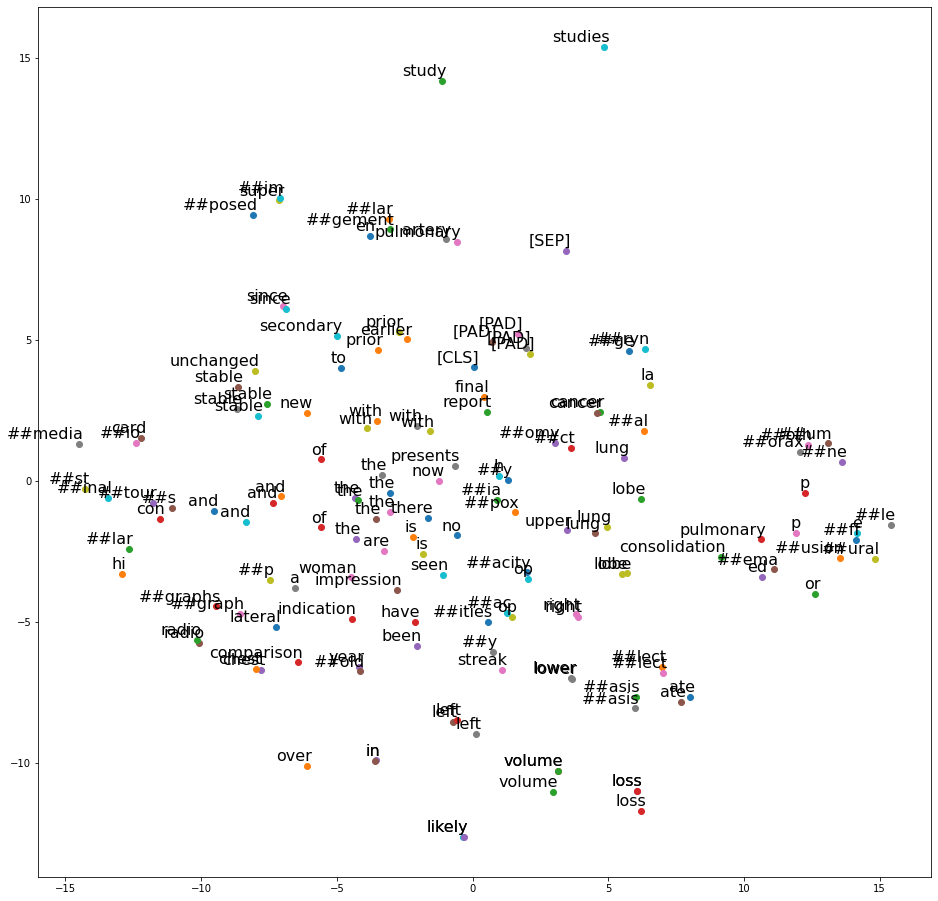

In [135]:
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(tokensArray)

x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(16, 16)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom', 
                 fontsize=16)
    #plt.xlim([-400, 400])
    #plt.ylim([-400, 400])
plt.show()

### Word Predictions

In [65]:
from transformers import pipeline

mask_filler_ft = pipeline(
    "fill-mask", model="ICLbioengNLP/CXR_BioClinicalBERT_chunkedv1")

mask_filler_original = pipeline(
    "fill-mask", model="emilyalsentzer/Bio_ClinicalBERT")

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [164]:
example = padded_dataset["test"]["input_ids"][5]
example_word = tokenizer.convert_ids_to_tokens(example)
# for elem in example_word:
#     print(example_word.index(elem), " ", elem)
    
# index = random.choice(range(10,50))
index = 48
print("Word to predict: ", 
      example_word[index-7], example_word[index-6], example_word[index-5], example_word[index-4], example_word[index-3], example_word[index-2], example_word[index-1], 
      ">>> ", example_word[index], " <<< ", 
      example_word[index+1], example_word[index+2], example_word[index+3], example_word[index+4], example_word[index-5], example_word[index+6], example_word[index+7])

example[index] = 103
text1 = tokenizer.decode(example)

Word to predict:  the same day obtained earlier there is >>>  prominence  <<<  of the right para day ##che ##al


In [165]:
preds1_ft = mask_filler_ft(text1)
preds1_org = mask_filler_original(text1)

print("Predictions for text1:")
print("1. Pre-trained Bio_ClinicalBERT")
for pred in preds1_org:
    format_score = "{:.5f}".format(pred["score"])
    print("Score: ", format_score, " ", pred["token_str"])
print()
print("2. Fine-tuned CXR_BioClinicalBERT_chunkedv1")
for pred in preds1_ft:
    format_score = "{:.5f}".format(pred["score"])
    print("Score: ", format_score, " ", pred["token_str"])

Predictions for text1:
1. Pre-trained Bio_ClinicalBERT
Score:  0.14050   appearance
Score:  0.09987   loss
Score:  0.06459   progression
Score:  0.04244   preservation
Score:  0.03585   compression

2. Fine-tuned CXR_BioClinicalBERT_chunkedv1
Score:  0.80710   widening
Score:  0.16841   prominence
Score:  0.01292   loss
Score:  0.00225   narrowing
Score:  0.00205   absence
